In [1]:
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, roc_auc_score

/Applications/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
data95=pd.read_csv('/Users/wsswemily/Desktop/GOM/Amazon/machadinho_data_1995.csv')
data95=data95.iloc[:1108,6:68]
names=data95.columns.values
names

array(['rate', 'people', 'arrival', 'goods', 'chainsaw', 'planter',
       'Hhedu', 'Hhwedu', 'knowledge', 'dirtwater', 'bednet', 'DDT',
       'insecticide', 'tea', 'region', 'pasture', 'cleared', 'rooms',
       'wall', 'roof', 'sealing', 'getwater', 'bath', 'topography',
       'how got', 'whysold', 'dforest', 'driver', 'dwater', 'dwell',
       'loan-agr', 'loan-part', 'loan-eq', 'community', 'livedrural+1y',
       'chickenpork', 'dcurral', 'arrivRO', 'rice', 'corn', 'bean',
       'cassava', 'coffee', 'cocoa', 'banana', 'rubber', 'guarana', 'nut',
       'pepper', 'Dist.neighb', '900MFOREST', '1000mRiver', 'Unico dono',
       'roadquality', 'dist-health-Km', 'dist-hosp', 'v212', 'v403',
       'v720', 'v601', 'v606c', 'v608c'], dtype=object)

(array([ 511.,  248.,  165.,   60.,   50.,   31.,   13.,   13.,    7.,   10.]),
 array([-2.30258509, -2.06279557, -1.82300604, -1.58321651, -1.34342698,
        -1.10363746, -0.86384793, -0.6240584 , -0.38426887, -0.14447935,
         0.09531018]),
 <a list of 10 Patch objects>)

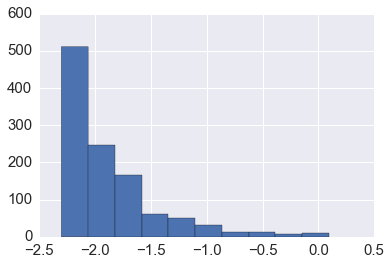

In [3]:
data95=np.array(np.transpose(data95))
data95[0]=np.log(data95[0]+0.1)
plt.hist(data95[0])

In [4]:
#turn rate into 0 or 1
for i in range(data95.shape[1]):
    if data95[0][i]<-2.06279557:
        data95[0][i]=0
    else:
        data95[0][i]=1

In [12]:
names

array(['rate', 'people', 'arrival', 'goods', 'chainsaw', 'planter',
       'Hhedu', 'Hhwedu', 'knowledge', 'dirtwater', 'bednet', 'DDT',
       'insecticide', 'tea', 'region', 'pasture', 'cleared', 'rooms',
       'wall', 'roof', 'sealing', 'getwater', 'bath', 'topography',
       'how got', 'whysold', 'dforest', 'driver', 'dwater', 'dwell',
       'loan-agr', 'loan-part', 'loan-eq', 'community', 'livedrural+1y',
       'chickenpork', 'dcurral', 'arrivRO', 'rice', 'corn', 'bean',
       'cassava', 'coffee', 'cocoa', 'banana', 'rubber', 'guarana', 'nut',
       'pepper', 'Dist.neighb', '900MFOREST', '1000mRiver', 'Unico dono',
       'roadquality', 'dist-health-Km', 'dist-hosp', 'v212', 'v403',
       'v720', 'v601', 'v606c', 'v608c'], dtype=object)

In [3]:
envir=[0,15,16,17,18,19,20,21,22,23,26,27,28,29,36,38,39,40,41,42,43,44,45,46,47,48,49,50,
      51,53,54,55]
behav=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,24,25,30,31,32,33,34,35,37,52,56,57,58,59,60,61]

In [4]:
names.shape

(62,)

In [8]:
def MELD_Backward_features(data, Numfolds, features):
    """This function performs supervised MELD and backward elimination algorithm
    Parameters:
        Input: a dataframe and number of folds
        output: select maximum AUC and corresponding features 
        for every specific number of features  
    """
    #divide data into kf cross validation folds
    kf=KFold(data.shape[1],Numfolds,shuffle=False,random_state=111)
    
    def profile_class(data,phi):
        """This function calculates the GoM scores for each individual
        Parameters:
        Input: data and phi calculate from MELD
           Output: GoM score
        """
        score=np.zeros([data.shape[1],2])
        profile=np.zeros([int(data.shape[0]),int(data.shape[1])])
        for j in range(data.shape[1]):
            for i in range(data.shape[0]):
                yij=int(data[i,j])
                #calculate M_ij
                profile[i,j]=np.argmax(phi[i][:,yij])
                if profile[i,j]==0:
                    score[j,0]=score[j,0]+1
                else:
                    score[j,1]=score[j,1]+1
            score[j,:]=(score[j,:]+0.1)/(phi.shape[0]+0.2)
        return score
    
    #create a list of features
    vec_list=[]
    for j in range(len(features)-1):
        integers=features[:]
        del integers[j+1]
        vec_list.append(integers)
    
    auc_list_outer=[]
    whole_gom_list=[]
    for j in range(len(vec_list)):
        auc_list=[]
        gom_list=[]
        vec=vec_list[j]
        for i in range(Numfolds):
            train=data[:,list(kf)[i][0]]
            test=data[:,list(kf)[i][1]]
            import MELD_95 as MELD
            k=2
            S=100
            Y = train
            (p,n) = Y.shape
            Yt = np.array([0]*p)
            Yt[0]=0
            # create an object of MELD class
            myMELD = MELD.MELD(Y,Yt,k,vec)
            # calculate second moment matrices
            myMELD.calM2()
            myMELD.calM2_bar()
            # ------------- first stage
            # initialize weight matrices to identity
            myMELD.initializeWeight_M2()
            # perform first stage estimation
            Result1 = myMELD.estimatePhiGrad_M2(S)
            # extract phi from the result
            phi1=Result1['PHI'][Result1['iter']]
            # extract selected features in the test fold
            test=test[vec]
            # calculate GoM score
            gscore=profile_class(test[1:],phi1[1:])
            # calculate risk
            risk=gscore[:,None]*np.transpose(phi1[0])
            risk=np.sum(risk[:,1,:],axis=1)
            gom_list.append(gscore[:,1])
            # replace 0 with label "-1"
            np.place(test[0],test[0]==0,[-1])
            # calculate AUC
            auc = roc_auc_score(test[0],risk)
            auc_list.append(auc)
        #calculate the mean AUC across kf folds
        auc_new=np.mean(auc_list)
        auc_list_outer.append(auc_new)
        whole_gom_list.append(list(np.concatenate(gom_list)))
        
    auc_all=[]
    vec_all=[]
    gom_all=[]
    while len(vec_list)>2:
        vec_list_2=vec_list[np.argmax(auc_list_outer).astype(int)] 
        gom_list_2=whole_gom_list[np.argmax(auc_list_outer).astype(int)]
        vec_all.append(vec_list_2)
        gom_all.append(gom_list_2)
        vec_list=[]
        whole_gom_list=[]
        #eliminate one feature at a time
        for k in range(len(vec_list_2)-1):
            integers=vec_list_2[:]
            del integers[k+1]
            vec_list.append(integers)

        auc_list_outer=[] 
       
        for j in range(len(vec_list)):
            auc_list=[]
            gom_list=[]
            vec=vec_list[j]

            for i in range(10):
            
                train=data[:,list(kf)[i][0]]
    
                test=data[:,list(kf)[i][1]]
        
                import MELD_95 as MELD
                k=2
                S=100

                Y = train
                (p,n) = Y.shape

                Yt = np.array([0]*p)
                Yt[0]=0
                # create an object of MELD class
                myMELD = MELD.MELD(Y,Yt,k,vec)

                # calculate second moment matrices
                myMELD.calM2()
                myMELD.calM2_bar()

                # ------------- first stage
                # initialize weight matrices to identity
                myMELD.initializeWeight_M2()

                # perform first stage estimation
                Result1 = myMELD.estimatePhiGrad_M2(S)
                # extract phi from the result
                phi1=Result1['PHI'][Result1['iter']]
                # extract selected features from test fold
                test=test[vec]
                # calculate GoM score
                gscore=profile_class(test[1:],phi1[1:])
                # calculate risk
                risk=gscore[:,None]*np.transpose(phi1[0])
                risk=np.sum(risk[:,1,:],axis=1)
                gom_list.append(gscore[:,1])
                # replace 0 with label "-1"
                np.place(test[0],test[0]==0,[-1])
                # calculate AUC
                auc = roc_auc_score(test[0],risk)
                auc_list.append(auc)
            # calculate average AUC across kf folds
            auc_new=np.mean(auc_list)     
            auc_list_outer.append(auc_new)
            whole_gom_list.append(list(np.concatenate(gom_list)))
              
        
        # selected the maximum AUC from a list of AUC's
        auc_new_new=max(auc_list_outer)
    
        auc_all.append(auc_new_new)
        
        auc=np.max(auc_all)
        
        feature_selected=vec_all[np.argmax(auc_all)]
        
        gom=gom_all[np.argmax(auc_all)]
    
    return auc, feature_selected, gom






In [23]:
out_envir=MELD_Backward_features(data95, 10, envir)

/Users/wsswemily/Desktop/SMELD/MELD_95.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_95.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

In [24]:
out_behav=MELD_Backward_features(data95, 10, behav)

/Users/wsswemily/Desktop/SMELD/MELD_95.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_95.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

In [25]:
names[out_envir[1]]


array(['rate', 'cleared', 'rooms', 'roof', 'sealing', 'bath', 'dforest',
       'driver', 'dcurral', 'rice', 'cocoa', 'banana', 'rubber', 'pepper',
       'dist-hosp'], dtype=object)

In [26]:
out_envir[0]

0.62933881548947002

In [27]:
gom_envir=out_envir[2]

In [28]:
names[out_behav[1]]

array(['rate', 'chainsaw', 'Hhwedu', 'bednet', 'how got', 'loan-part',
       'arrivRO', 'v212', 'v403'], dtype=object)

In [29]:
out_behav[0]

0.62835913448114611

In [30]:
gom_behav=out_behav[2]

In [43]:
def plot_GOM(gom_envir, gom_behav):
    fig = plt.figure(figsize=[8,5])
    #Generate a list of unique points
    points=list(set(zip(gom_behav,gom_envir))) 
    #Generate a list of point counts
    count=[len([x for x,y in zip(gom_behav,gom_envir) if x==p[0] and y==p[1]]) for p in points]
    #Now for the plotting:
    plot_x=[i[0] for i in points]
    plot_y=[i[1] for i in points]
    count=np.array(count)
    plt.scatter(plot_x,plot_y,c=count,s=100*count**0.5,cmap='Spectral_r')
    plt.xlabel('Behavioral GoM Score')
    plt.ylabel('Environmental GoM Score')
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    fig.suptitle('GoM Scores for the Machadinho data in 1995',fontsize=16)
    plt.show()
    fig.savefig('GOM95.pdf')

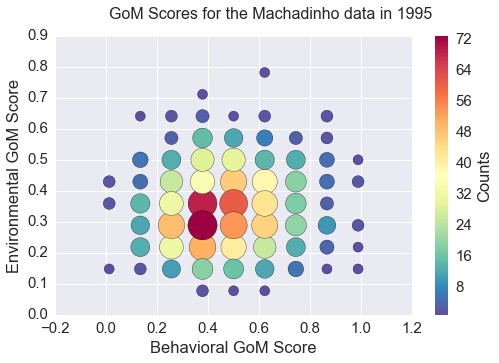

In [44]:
plot_GOM(gom_envir,gom_behav)

(array([ 511.,  248.,  165.,   60.,   50.,   31.,   13.,   13.,    7.,   10.]),
 array([-2.30258509, -2.06279557, -1.82300604, -1.58321651, -1.34342698,
        -1.10363746, -0.86384793, -0.6240584 , -0.38426887, -0.14447935,
         0.09531018]),
 <a list of 10 Patch objects>)

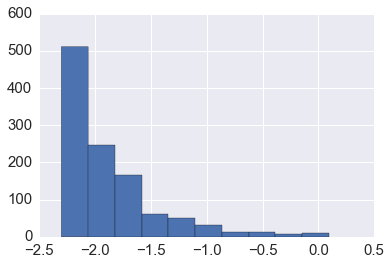

In [7]:
for i in range(1,data95.shape[1]):
    data95.iloc[:,i]=data95.iloc[:,i].astype('category')
cat_columns = data95.select_dtypes(['category']).columns
data95[cat_columns] = data95[cat_columns].apply(lambda x: x.cat.codes)
data95=np.array(data95)
data95=np.transpose(data95)
data95[0]=np.log(data95[0]+0.1)
plt.hist(data95[0])

In [8]:
#turn rate into 0 or 1
for i in range(data95.shape[1]):
    if data95[0][i]<-2.06279557:
        data95[0][i]=0
    else:
        data95[0][i]=1

In [9]:
kf1=KFold(data95.shape[1],10,shuffle=False, random_state=111)
from sklearn.svm import LinearSVC, SVC

In [12]:
auc_list_svm1=[]
np.place(data95[0],data95[0]==0,-1)
for i in range(10):
    train=np.transpose(data95[envir][:,list(kf1)[i][0]])
    
    test=np.transpose(data95[envir][:,list(kf1)[i][1]])
    
    svmc=SVC(random_state=111,probability=True)
    
    svm=svmc.fit(train[:,1:],train[:,0])
    
    #use predicted probabilities to construct ROC curve and AUC score
    soft_pred_svm = svm.predict_proba(test[:,1:])
        
    fpr_svm,tpr_svm,thresh_svm = roc_curve(test[:,0],soft_pred_svm[:,1])
    
    auc_svm=roc_auc_score(test[:,0],soft_pred_svm[:,1])
                
    auc_list_svm1.append(auc_svm)
    
    #plt.plot(fpr_svm,tpr_svm)
        
    #plt.plot([0,1],[0,1],"r--",alpha=.5)
    
    #plt.show()
    print("AUC: {}".format(auc_svm))

AUC: 0.6455026455026455
AUC: 0.7260869565217392
AUC: 0.6438098495212039
AUC: 0.5844771241830066
AUC: 0.5007911392405063
AUC: 0.5421052631578948
AUC: 0.6116362451108214
AUC: 0.6704980842911877
AUC: 0.509641873278237
AUC: 0.5810439560439561


In [13]:
np.mean(auc_list_svm1)

0.60155931368511983

In [14]:
auc_list_svm2=[]
for i in range(10):
    train=np.transpose(data95[behav][:,list(kf1)[i][0]])
    
    test=np.transpose(data95[behav][:,list(kf1)[i][1]])
    
    svmc=SVC(random_state=111,probability=True)
    
    svm=svmc.fit(train[:,1:],train[:,0])
    
    #use predicted probabilities to construct ROC curve and AUC score
    soft_pred_svm = svm.predict_proba(test[:,1:])
        
    fpr_svm,tpr_svm,thresh_svm = roc_curve(test[:,0],soft_pred_svm[:,1])
    
    auc_svm=roc_auc_score(test[:,0],soft_pred_svm[:,1])
                
    auc_list_svm2.append(auc_svm)
    
    #plt.plot(fpr_svm,tpr_svm)
        
    #plt.plot([0,1],[0,1],"r--",alpha=.5)
    
    #plt.show()
    print("AUC: {}".format(auc_svm))

AUC: 0.6931216931216931
AUC: 0.6588628762541806
AUC: 0.5711354309165526
AUC: 0.6761437908496732
AUC: 0.618868670886076
AUC: 0.48270676691729325
AUC: 0.6584093872229465
AUC: 0.6475095785440613
AUC: 0.5859897678079495
AUC: 0.6369047619047619


In [15]:
np.mean(auc_list_svm2)

0.62296527244251876

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
auc_list_rf1=[]
for i in range(10):
    train_4=np.transpose(data95[envir][:,list(kf1)[i][0]])
    
    test_4=np.transpose(data95[envir][:,list(kf1)[i][1]])
    
    RFC=RandomForestClassifier(random_state=111)
    
    rf=RFC.fit(train_4[:,1:],train_4[:,0])
    
    #use predicted probabilities to construct ROC curve and AUC score
    soft_pred_rf = rf.predict_proba(test_4[:,1:])
        
    fpr_rf,tpr_rf,thresh_rf = roc_curve(test_4[:,0],soft_pred_rf[:,1])
    
    auc_rf=roc_auc_score(test_4[:,0],soft_pred_rf[:,1])
                
    auc_list_rf1.append(auc_rf)
    
    print("AUC: {}".format(auc_rf))


AUC: 0.505026455026455
AUC: 0.6444816053511707
AUC: 0.5928522571819426
AUC: 0.6459150326797386
AUC: 0.598496835443038
AUC: 0.47763157894736835
AUC: 0.6033246414602347
AUC: 0.6855842911877394
AUC: 0.5629673356946083
AUC: 0.48992673992673985


In [18]:
np.mean(auc_list_rf1)

0.58062067728990363

In [19]:
auc_list_rf2=[]
for i in range(10):
    train_4=np.transpose(data95[envir][:,list(kf1)[i][0]])
    
    test_4=np.transpose(data95[envir][:,list(kf1)[i][1]])
    
    RFC=RandomForestClassifier(random_state=111)
    
    rf=RFC.fit(train_4[:,1:],train_4[:,0])
    
    #use predicted probabilities to construct ROC curve and AUC score
    soft_pred_rf = rf.predict_proba(test_4[:,1:])
        
    fpr_rf,tpr_rf,thresh_rf = roc_curve(test_4[:,0],soft_pred_rf[:,1])
    
    auc_rf=roc_auc_score(test_4[:,0],soft_pred_rf[:,1])
                
    auc_list_rf2.append(auc_rf)
    
    print("AUC: {}".format(auc_rf))


AUC: 0.505026455026455
AUC: 0.6444816053511707
AUC: 0.5928522571819426
AUC: 0.6459150326797386
AUC: 0.598496835443038
AUC: 0.47763157894736835
AUC: 0.6033246414602347
AUC: 0.6855842911877394
AUC: 0.5629673356946083
AUC: 0.48992673992673985


In [20]:
np.mean(auc_list_rf2)

0.58062067728990363

In [9]:
out_all=MELD_Backward_features(data95, 10, list(range(data95.shape[0])))

/Users/wsswemily/Desktop/SMELD/MELD_95.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j = np.zeros((n,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_j[i,Y[j,i]] = 1
/Users/wsswemily/Desktop/SMELD/MELD_95.py:76: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.X[j] = np.zeros((k,self.d[j]))
/Users/wsswemily/Desktop/SMELD/MELD_95.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.Phi[j][h,:] = np.random.dirichlet([100.0]*self.d[j])
/Users/wss

In [11]:
out_all

(0.65925200148651375,
 [0, 4, 7, 17, 26, 27, 36, 43, 44, 48, 55, 56, 57],
 [0.41803278688524592,
  0.41803278688524592,
  0.33606557377049179,
  0.33606557377049179,
  0.25409836065573771,
  0.25409836065573771,
  0.33606557377049179,
  0.41803278688524592,
  0.33606557377049179,
  0.17213114754098363,
  0.25409836065573771,
  0.33606557377049179,
  0.5,
  0.5,
  0.41803278688524592,
  0.5,
  0.25409836065573771,
  0.33606557377049179,
  0.41803278688524592,
  0.17213114754098363,
  0.25409836065573771,
  0.33606557377049179,
  0.17213114754098363,
  0.5,
  0.5,
  0.41803278688524592,
  0.17213114754098363,
  0.58196721311475408,
  0.25409836065573771,
  0.17213114754098363,
  0.33606557377049179,
  0.33606557377049179,
  0.25409836065573771,
  0.25409836065573771,
  0.41803278688524592,
  0.33606557377049179,
  0.090163934426229525,
  0.25409836065573771,
  0.17213114754098363,
  0.33606557377049179,
  0.25409836065573771,
  0.33606557377049179,
  0.090163934426229525,
  0.17213114754

In [15]:
np.array([envir])

array([[ 0, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 36, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55]])

In [16]:
np.array([behav])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 24, 25,
        30, 31, 32, 33, 34, 35, 37, 52, 56, 57, 58, 59, 60, 61]])

In [17]:
out_all[1]

[0, 4, 7, 17, 26, 27, 36, 43, 44, 48, 55, 56, 57]

In [22]:
names[np.array([17,26,27,36,43,44,48,55])]

array(['rooms', 'dforest', 'driver', 'dcurral', 'cocoa', 'banana',
       'pepper', 'dist-hosp'], dtype=object)

In [23]:
names[np.array([4,7,56,57])]

array(['chainsaw', 'Hhwedu', 'v212', 'v403'], dtype=object)